In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_05b import *
torch.set_num_threads(2)

## ConvNet

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=3641)

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

Helper function to quickly normalize with the mean and standard deviation from our training set:

In [4]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

Let's check it behaved properly.

In [6]:
x_train.mean(),x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [7]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

To refactor layers, it's useful to have a `Lambda` layer (extending nn.Module and implementing a forward method) that can take a basic function and convert it to a layer you can put in `nn.Sequential`.

NB: if you use a Lambda layer with a lambda function, your model won't pickle so you won't be able to save it with PyTorch. So it's best to give a name to the function you're using inside your Lambda (like flatten below).

In [8]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

This flatten function removes the axis at the end after the adaptive average pooling:

In [9]:
#export
def flatten(x):      return x.view(x.shape[0], -1)

This one takes the flat vector of size `bs x 784` and puts it back as a batch of images of 28 by 28 pixels (what nn.Conv2d expects):

In [10]:
def mnist_resize(x): return x.view(-1, 1, 28, 28) # -1: batch size remains as before

We can now define a simple CNN model:

In [11]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14x14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7x7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4x4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2x2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [12]:
model = get_cnn_model(data)

Basic callbacks from the previous notebook:

In [13]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [14]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [15]:
%time run.fit(1, learn)

train: [1.91182171875, tensor(0.3346)]
valid: [0.9688099609375, tensor(0.6814)]
Wall time: 16.2 s


## CUDA

This took a long time to run, so it's time to use a GPU. A simple Callback can make sure the model, inputs and targets are all on the same device.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=3799)

In [16]:
torch.cuda.is_available()

True

Somewhat more flexible way:

In [17]:
device = torch.device('cuda',0)

In [18]:
class CudaCallback(Callback):
    def __init__(self,device): 
        self.device=device
        
    def begin_fit(self): 
        self.model.to(self.device)
        
    def begin_batch(self): 
        self.run.xb,self.run.yb = self.xb.to(self.device),self.yb.to(self.device)

Somewhat less flexible, but quite convenient when using only 1 GPU:

In [19]:
torch.cuda.set_device(device) # we set everything to this device

In [20]:
#export
class CudaCallback(Callback):
    def begin_fit(self): 
        self.model.cuda()
        
    def begin_batch(self): 
        self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [21]:
cbfs.append(CudaCallback)

In [22]:
model = get_cnn_model(data)

In [23]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [24]:
%time run.fit(3, learn)

train: [2.24017015625, tensor(0.1728, device='cuda:0')]
valid: [2.4739158203125, tensor(0.2250, device='cuda:0')]
train: [0.83928109375, tensor(0.7263, device='cuda:0')]
valid: [0.33597177734375, tensor(0.8880, device='cuda:0')]
train: [0.2765924609375, tensor(0.9147, device='cuda:0')]
valid: [0.20006922607421876, tensor(0.9398, device='cuda:0')]
Wall time: 6.07 s


Now, that's definitely faster!

## Refactor model

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=3961)

First we can regroup all the conv/relu in a single function, with default values:

In [25]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

Another thing is that we can do the mnist resize in a batch transform, by using a Callback; so we can remove it from the model.

In [26]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): 
        self.tfm = tfm
    def begin_batch(self): 
        self.run.xb = self.tfm(self.xb) 

def view_tfm(*size):
    def _inner(x): 
        return x.view(*((-1,)+size))
    return _inner

In [27]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

With the `AdaptiveAvgPool`, this model can now work on any size input.

We define a list with the number of filters for each layer:

In [28]:
nfs = [8,16,32,32]

In [29]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3) for i in range(len(nfs)-1)] \
        + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): 
    return nn.Sequential(*get_cnn_layers(data, nfs))

And this helper function will quickly give us everything needed to run the training.

In [30]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [31]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [32]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [33]:
run.fit(3, learn)

train: [1.939564375, tensor(0.3173, device='cuda:0')]
valid: [1.21837900390625, tensor(0.6097, device='cuda:0')]
train: [0.454374765625, tensor(0.8599, device='cuda:0')]
valid: [0.19033590087890626, tensor(0.9458, device='cuda:0')]
train: [0.19923255859375, tensor(0.9386, device='cuda:0')]
valid: [0.133166015625, tensor(0.9600, device='cuda:0')]


## Hooks

### Manual insertion

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=4353)

Let's say we want to do some telemetry, and want the mean and standard deviation of each activations in the model. First we can do it manually by rewriting nn.Sequential just like this:

In [34]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean()) # save mean
            self.act_stds [i].append(x.data.std ()) # save std dev
        return x
    
    def __iter__(self): return iter(self.layers)

In [35]:
l = ['layer1', 'layer2', 'layer3']
[[] for _ in l]

[[], [], []]

In [36]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [37]:
run.fit(2, learn)

train: [2.27345078125, tensor(0.1779, device='cuda:0')]
valid: [1.7282828125, tensor(0.4239, device='cuda:0')]
train: [1.754428125, tensor(0.4026, device='cuda:0')]
valid: [0.8519275390625, tensor(0.7199, device='cuda:0')]


Now we can have a look at the means and stds of the activations at the beginning of training.

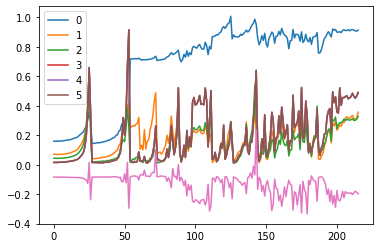

In [38]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6));

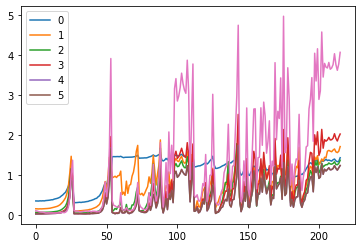

In [39]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));

Let's take a look to the first 10 batches:

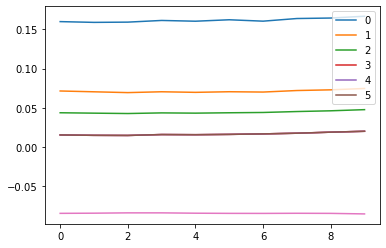

In [40]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6));

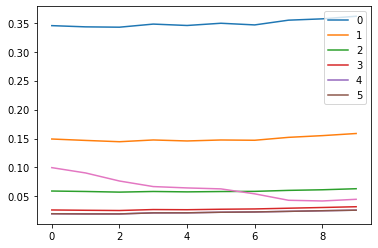

In [41]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

Bad thing: the std dev decreases as we advance with layers, becoming really near to zero.

OK. We need a better way of adding this telemmetry, not by rewriting classes. But we can't use callbacks if we use PyTorch to execute code after a layer application, in the forward or in the backward pass (inner things!). And that's why we use hooks, which are esentially the same thing that callbacks but they call them this way :)

### Pytorch hooks

Hooks are PyTorch objects you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook).

Hooks don't require us to rewrite the model. It's actually callbacks :)

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=4693)

In [42]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [43]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

A hook is attached to a layer, and needs to have a function that takes three arguments: the module doing the callback, the input to the module, and its output. Here we store the mean and std dev of the output in the correct position of our list.

In [44]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())

We must use `register_forward_hook` to indicate which function will be called after every forward pass is calculated in a module/layer (`register_backward_hook` to apply a function in the backward pass):

In [45]:
for i,m in enumerate(model): 
    m.register_forward_hook(partial(append_stats, i))

In [46]:
run.fit(1, learn)

train: [2.00349578125, tensor(0.3063, device='cuda:0')]
valid: [1.114502734375, tensor(0.6490, device='cuda:0')]


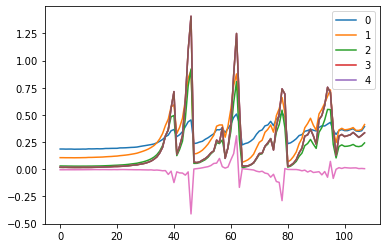

In [47]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

### Hook class

We can refactor this in a Hook class, to avoid global variables and other things. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=4836)

In [48]:
#export
def children(m): 
    return list(m.children())

class Hook():
    def __init__(self, m, f): 
        self.hook = m.register_forward_hook(partial(f, self)) # ties the function to (it)self
    def remove(self): 
        self.hook.remove()
    def __del__(self): # called when python frees memory
        self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): 
        hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

We can test the last part works:

In [49]:
hook_stats = ([],[])
means,stds = hook_stats
means.append(0)
stds.append(1)
hook_stats

([0], [1])

NB: In fastai we use a `bool` param to choose whether to make it a forward or backward hook. In the above version we're only supporting forward hooks.

In [50]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [51]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [52]:
run.fit(1, learn)

train: [1.995781875, tensor(0.3035, device='cuda:0')]
valid: [0.83456337890625, tensor(0.7230, device='cuda:0')]


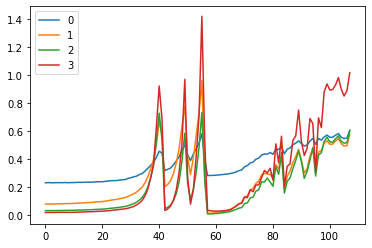

In [53]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

### A Hooks class

Let's first design our own class that can contain a list of objects, instead of using a simple list. It will behave a bit like a numpy array (not allowed here) in the sense that we can index into it via:
- a single index
- a slice (like 1:5)
- a list of indices
- a mask of indices (`[True,False,False,True,...]`)

The `__iter__` method is there to be able to do things like `for x in ...`.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=4972)

In [54]:
#export
class ListContainer():
    def __init__(self, items): 
        self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): 
            return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): 
        return len(self.items)
    def __iter__(self): 
        return iter(self.items)
    def __setitem__(self, i, o): 
        self.items[i] = o
    def __delitem__(self, i): 
        del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: 
            res = res[:-1]+ '...]'
        return res

In [55]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [56]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

The ellipsis is what we implemented in the `__repr__` method :)

We can index items or mask them:

In [57]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

We can use it to write a `Hooks` class that contains several hooks. We will also use it in the next notebook as a container for our objects in the data block API.

In [58]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): 
        super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): 
        return self
    def __exit__ (self, *args): 
        self.remove()
    def __del__(self): 
        self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: 
            h.remove()

Let's start again from the beginning:

In [59]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [60]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x000001C01590FB48>, <__main__.Hook object at 0x000001C01590F148>, <__main__.Hook object at 0x000001C01590F108>, <__main__.Hook object at 0x000001C01590FC08>, <__main__.Hook object at 0x000001C01590F1C8>, <__main__.Hook object at 0x000001C01590F448>, <__main__.Hook object at 0x000001C015955C48>]

In [61]:
hooks.remove()

In [62]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [63]:
x.mean(),x.std()

(tensor(-0.0046, device='cuda:0'), tensor(0.9951, device='cuda:0'))

In [64]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.1349, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3466, device='cuda:0', grad_fn=<StdBackward0>))

Low value for the std dev. So let's apply initializacion with kaiming:

In [65]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [66]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.4169, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.5553, device='cuda:0', grad_fn=<StdBackward0>))

That's better :) (mean is near 0.5 because of the ReLU).

Having given an `__enter__` and `__exit__` method to our `Hooks` class, we can use it as a **context manager**. This makes sure that once we are out of the `with` block, all the hooks have been removed and aren't there to pollute our memory.

train: [1.80437359375, tensor(0.4112, device='cuda:0')]
valid: [0.80224482421875, tensor(0.7011, device='cuda:0')]
train: [0.549292421875, tensor(0.8204, device='cuda:0')]
valid: [0.249266064453125, tensor(0.9260, device='cuda:0')]


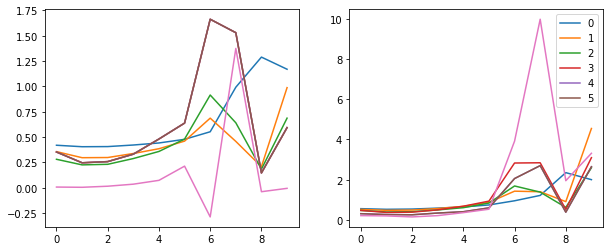

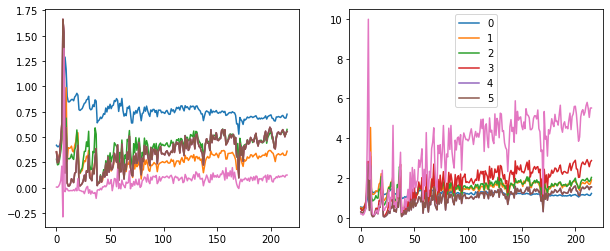

In [67]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    # first ten stats
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    # all stats
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

This time we don't have that exponential peak at the beginning :)

### Other statistics

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5233)

Let's store more than the means and stds and plot **histograms** of our activations now, so we can check what's happening inside...

In [68]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): 
        hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU #40 bins from 0 to 10

In [69]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [70]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [71]:
with Hooks(model, append_stats) as hooks: 
    run.fit(1, learn)

train: [1.17762453125, tensor(0.6175, device='cuda:0')]
valid: [0.208161865234375, tensor(0.9339, device='cuda:0')]


In [72]:
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): 
    return torch.stack(h.stats[2]).t().float().log1p()

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5582)

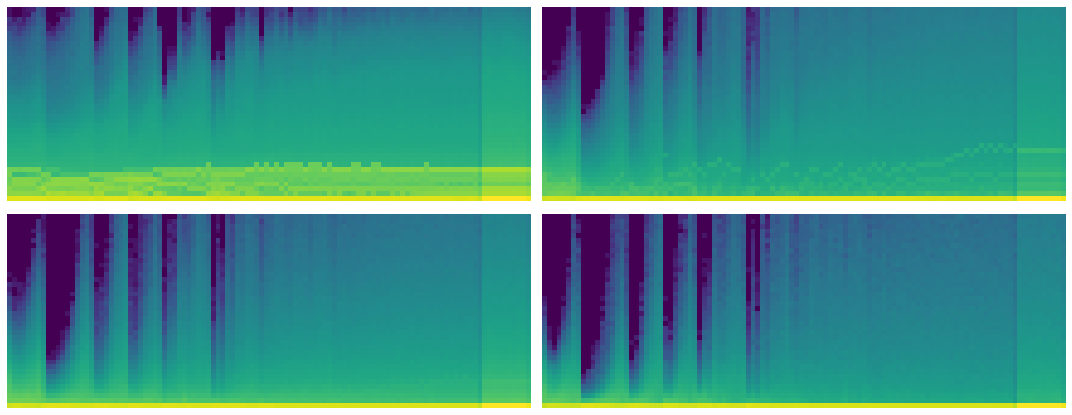

In [73]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

The x axis is the iteration number. The y axis show us how the activations are distributed over the 40 bins, having into account how high/low they are. The bottom yellow line indicates that a lot of the activations are 0 or nearly.

Read this: [Interpreting the colorful histograms used in this lesson](https://forums.fast.ai/t/the-colorful-dimension/42908)

From the histograms, we can easily get more detailed information, like the min or max of the activations. We can get the percetange of the activations that remains near to zero.

In [74]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0) # return percentage of the activations that are 0 or near 0

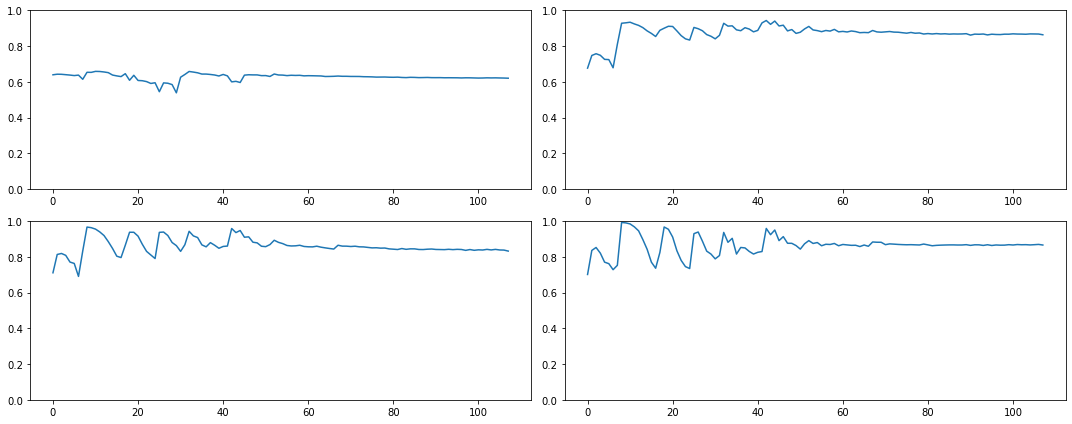

In [75]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

If we look at the last one (4th layer) we can see that nearly 90% of the activations are 0 or almost 0. That's a lot of wasted info! We'll never get great results with these numbers. It's very important to look at these plots although our training looks good.

We'll apply several things to fix this, but the most important one is a generalized ReLU.

## Generalized ReLU

Now let's use our model with a generalized ReLU that can be shifted, leaked, and with maximum value.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5390)

In [76]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [77]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7)) # from -7 because of the leakyness

In [78]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.484982890625, tensor(0.8462, device='cuda:0')]
valid: [0.1543530517578125, tensor(0.9550, device='cuda:0')]


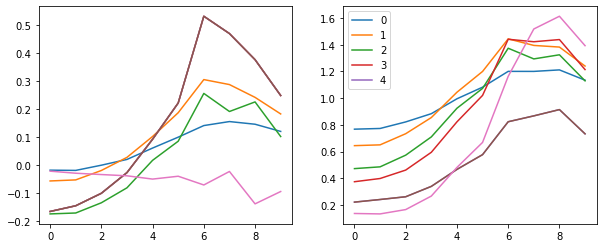

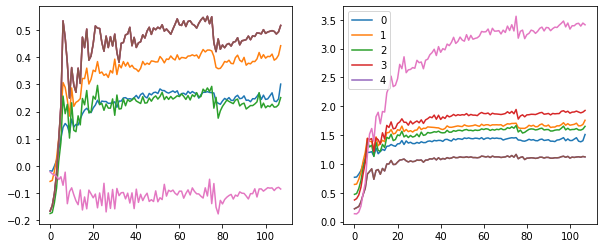

In [79]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

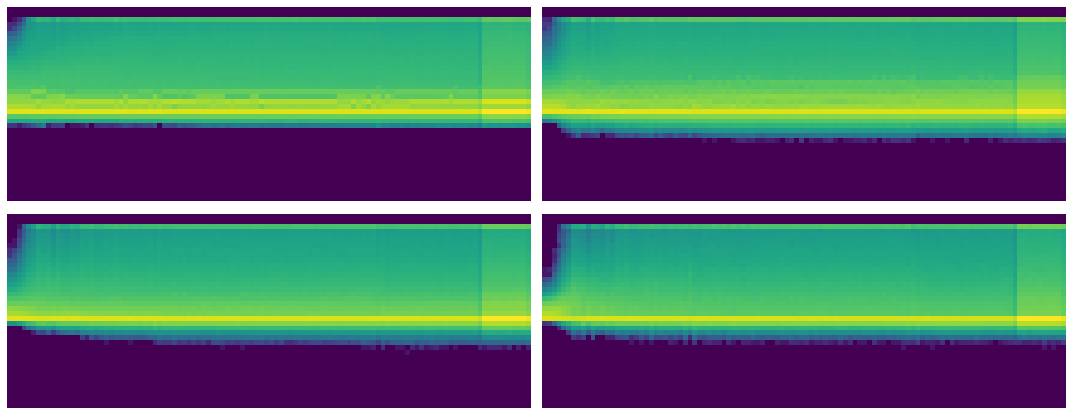

In [80]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [81]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

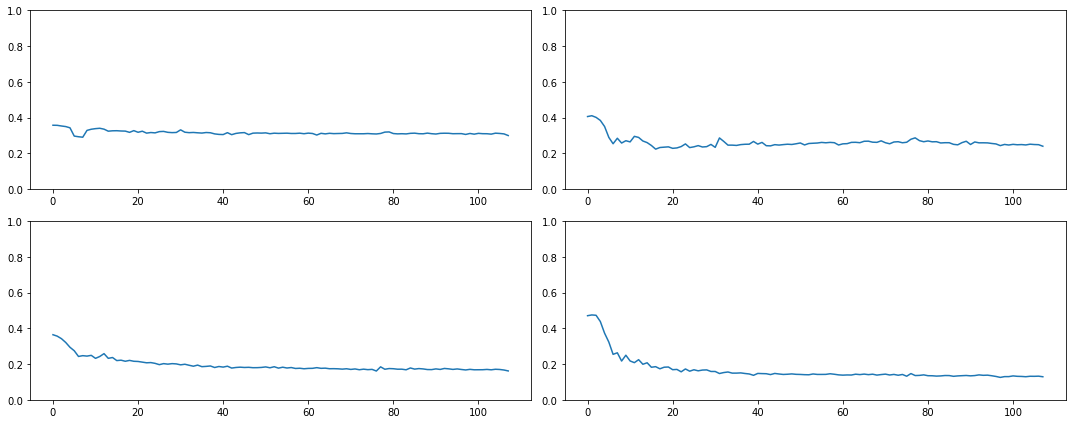

In [82]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

That's less than a 20% of the activations wasted :)

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5705)

Let's apply learning rate scheduling...

In [83]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [84]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 

In [85]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [86]:
run.fit(8, learn)

train: [1.06400640625, tensor(0.6616, device='cuda:0')]
valid: [0.3379185791015625, tensor(0.8950, device='cuda:0')]
train: [0.3708167578125, tensor(0.8860, device='cuda:0')]
valid: [0.18026591796875, tensor(0.9464, device='cuda:0')]
train: [0.27692197265625, tensor(0.9161, device='cuda:0')]
valid: [0.14176690673828124, tensor(0.9606, device='cuda:0')]
train: [0.1156838671875, tensor(0.9647, device='cuda:0')]
valid: [0.1264265869140625, tensor(0.9632, device='cuda:0')]
train: [0.08477599609375, tensor(0.9736, device='cuda:0')]
valid: [0.07645053100585937, tensor(0.9774, device='cuda:0')]
train: [0.058129677734375, tensor(0.9822, device='cuda:0')]
valid: [0.066110693359375, tensor(0.9819, device='cuda:0')]
train: [0.04304826171875, tensor(0.9872, device='cuda:0')]
valid: [0.05953843994140625, tensor(0.9829, device='cuda:0')]
train: [0.03486981689453125, tensor(0.9901, device='cuda:0')]
valid: [0.05834668579101562, tensor(0.9833, device='cuda:0')]


Uniform init **may** provide more useful initial weights because they are uniformly distributed :) (normal distribution puts a lot of them at 0).

In [87]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [88]:
run.fit(8, learn)

train: [0.990425703125, tensor(0.6831, device='cuda:0')]
valid: [0.2926234375, tensor(0.9118, device='cuda:0')]
train: [0.31878443359375, tensor(0.9034, device='cuda:0')]
valid: [0.17702059326171876, tensor(0.9471, device='cuda:0')]
train: [0.4992387109375, tensor(0.8494, device='cuda:0')]
valid: [0.19479716796875, tensor(0.9417, device='cuda:0')]
train: [0.15743923828125, tensor(0.9517, device='cuda:0')]
valid: [0.406313134765625, tensor(0.8684, device='cuda:0')]
train: [0.20079919921875, tensor(0.9389, device='cuda:0')]
valid: [0.09928057861328125, tensor(0.9697, device='cuda:0')]
train: [0.0751254736328125, tensor(0.9766, device='cuda:0')]
valid: [0.07073455810546875, tensor(0.9788, device='cuda:0')]
train: [0.0560559228515625, tensor(0.9829, device='cuda:0')]
valid: [0.0683289306640625, tensor(0.9792, device='cuda:0')]
train: [0.0474078173828125, tensor(0.9857, device='cuda:0')]
valid: [0.06679739990234375, tensor(0.9798, device='cuda:0')]


## Export

Here's a handy way to export our module without needing to update the file name - after we define this, we can just use `nb_auto_export()` in the future (h/t Stas Bekman):

In [89]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [ ]:
nb_auto_export()